# Ridge(L2 Regularization) Regression

## References

- https://www.youtube.com/watch?v=Q81RR3yKn30 (statquest)

## Generate Data

In [1]:
import pandas as pd 
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
import seaborn as sns

from matplotlib import animation
from IPython import display

from utility import regression_plot, regression_animation

In [2]:
def add_axis_for_bias(X_i):

    m, n = X_i.shape
    
    if False in (X_i[:,0] == 1):        
        return np.c_[np.ones(m) , X_i]
    else:
        return X_i

In [3]:
X, y = make_regression(n_samples=100, n_features=1, noise=20, random_state=0)
y = y.reshape(-1, 1)

np.random.seed(10)
random_idxs = np.random.randint(70, 100, size=30)

X[random_idxs, :] = X[random_idxs, :] + 5

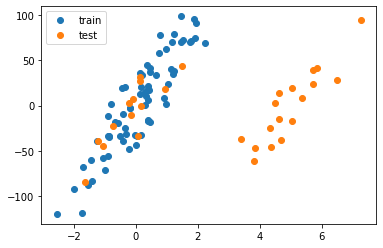

In [4]:
train_size = 70

plt.plot(X[:train_size], y[:train_size], 'o', label='train')
plt.plot(X[train_size:], y[train_size:], 'o', label='test')
plt.legend()
plt.show()

## Theory

- When sample sizes are relatively small then Ridge Regression can improve predictions made from new data (introducing bias and reducing variance) by making predictions less sensitive to training data.
- Even when there is no enough data to find least square solution, ridge regression can find a solution using cross validation and penalty.

<!-- ## Regularization
- keep all features, but reduce magnitude/ values of paramter $θ_j$
- Workes well when we have a lot of features, each of which contributes a bit to predicting y.
  -->

## Ridge with Normal Equation

### Loss Function

\begin{align}
    J(\theta) &= \frac{1}{2m} \big[{\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})^2 + \lambda \sum_{j=1}^{n}{\theta_j^2}} \big] \\
\end{align}



### Algorithm 
\begin{align}
\theta &= (X^T X + \lambda I)^{-1}  X^T  y
\end{align}

In [7]:
def ridge_regression_normaleq(X, y, penalty=1.0):
    X = add_axis_for_bias(X)    
    m, n = X.shape
    theta = np.linalg.inv(X.T @ X + (penalty * np.eye(n))) @ X.T @ y
    return theta


def predict(X, theta):
    format_X = add_axis_for_bias(X)
        
    if format_X.shape[1] == theta.shape[0]:
        y_pred = format_X @ theta # (m,1) = (m,n) * (n,1)
        return y_pred
    elif format_X.shape[1] == theta.shape[1]:
        y_pred = format_X @ theta.T # (m,1) = (m,n) * (n,1)
        return y_pred
    else:
        raise ValueError("Shape is not proper.")



### Training

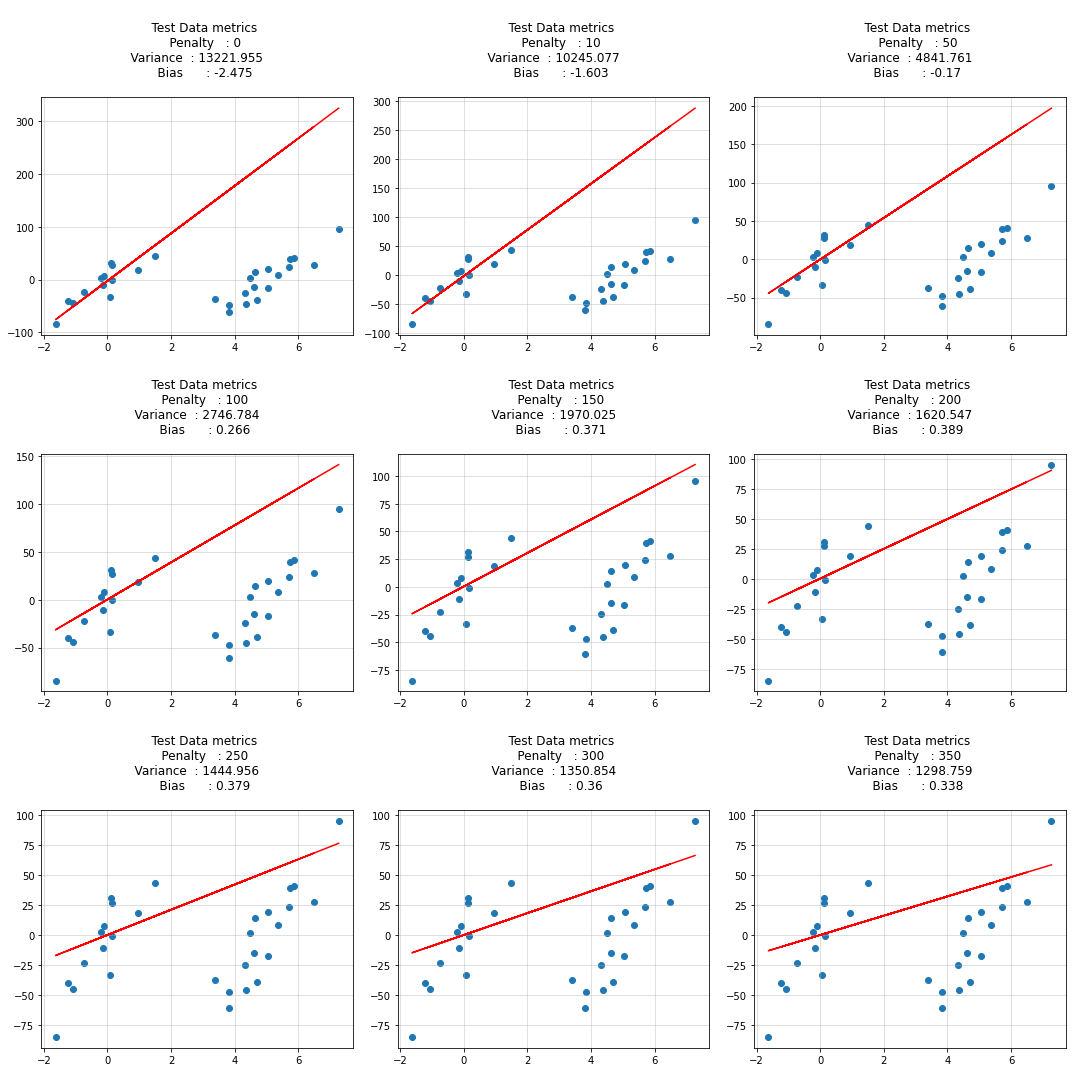

In [10]:
penalty_list = [0, 10, 50, 100, 150, 200, 250, 300, 350]
variance_list = []
bias_list = []

cols = 3
rows = np.int32(np.ceil(len(penalty_list)/ cols))

fig, ax = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
ax = ax.ravel()


for idx, penalty in enumerate(penalty_list):
    theta = ridge_regression_normaleq(X[:train_size], y[:train_size], penalty=penalty)
    y_hat = predict(X[train_size:], theta)
    variance = (y[train_size:] - y_hat).var(ddof=1)
    
    bias_list.append(theta[0])
    variance_list.append(variance)

    ax[idx].scatter(X[train_size:], y[train_size:])
    ax[idx].plot(X[train_size:], y_hat, c='r')
    
    ax[idx].set_title(f"""
    Test Data metrics
    Penalty   : {penalty}
    Variance  : {round(variance, 3)}    
    Bias      : {round(theta[0][0], 3)}
    """)
    ax[idx].grid(alpha=0.5)

plt.tight_layout()
plt.show()

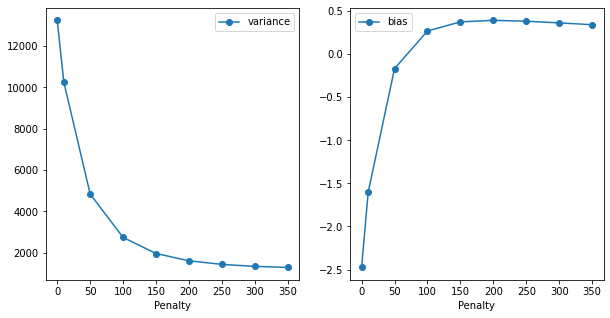

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(penalty_list, variance_list, 'o-', label='variance')
ax[0].set_xlabel("Penalty")
ax[0].legend()

ax[1].plot(penalty_list, bias_list, 'o-', label='bias')
ax[1].set_xlabel("Penalty")
ax[1].legend()

plt.show()

## Ridge with BGD


<!-- ### in code 

\begin{align}
\theta_j(1 - \frac{\alpha \lambda}{m}) - \alpha \frac{1}{m}{\sum_{i=1}^{m}{(h_\theta(x^{(i)}) - y^{(i)})}}.{x_j^{(i)}}
\end{align} -->

### Loss Function

\begin{align}
    J(\theta) &= \frac{1}{2m} \big[{\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})^2 + \lambda \sum_{j=1}^{n}{\theta_j^2}} \big] \\
\end{align}

### Algorithm



\begin{align}
   \text{derivative} = \frac{\partial{J(\theta)}}{\partial{\theta}} &=  \frac{1}{m}{\sum_{i=1}^{m}{(h_\theta(x^{(i)}) - y^{(i)})}}.{x_j^{(i)}} + \frac{\lambda}{m}{\theta_j}
\end{align}

\begin{align}
    \text{repeat until convergence \{}\\
    \theta_0 &:= \theta_0 - \alpha \frac{1}{m}{\sum_{i=1}^{m}{(h_\theta(x^{(i)}) - y^{(i)})}}.x_0^{(i)}\\
    \theta_j &:= \theta_j - \alpha \big{[} \frac{1}{m}{\sum_{i=1}^{m}{(h_\theta(x^{(i)}) - y^{(i)})}}.{x_j^{(i)}} + \frac{\lambda}{m}{\theta_j} \big{]}\\
    \text{\} j = 1,2,3,...,n}
\end{align} 

<!-- Ridge regression is very similar to least squares, except that the coefficients are estimated by minimizing a slightly different quantity. -->

In [45]:
def derivative(X, y, y_pred, penalty, theta):
    m, _ = X.shape
    return np.mean( ( y_pred - y ) * X, axis = 0 ) + (penalty * theta)

def calculate_cost(y_pred, y, penalty, theta):
    m = y.shape[0]
    return (np.square( y_pred - y ).sum() + (penalty * np.square(theta).sum())) / (2 * m)

def predict(X, theta):
    return X @ theta.T

<!-- - here $\theta_0$ will not be effected by penalty but rest of the theta's $\theta_1 ... \theta_n$ will be effected by it. -->

In [46]:
def ridge_regression_bgd(X, y, verbose=True, theta_precision = 0.001, alpha = 0.01,
                         iterations = 10000, penalty=1.0):
    
    X = add_axis_for_bias(X)
    m, n = X.shape

    theta_history = []
    cost_history = []

    # number of features+1 because of theta_0
    theta = np.random.rand(1,n) * theta_precision

    for iteration in range(iterations):
        # calculate y_pred 
        y_pred = X @ theta.T
        
        # new θ to replace old θ
        new_theta = None
        
        # simultaneous operation 
        gradient = derivative(X, y, y_pred, penalty, theta)
        new_theta = theta - (alpha *  gradient)

        if np.isnan(np.sum(new_theta)) or np.isinf(np.sum(new_theta)):
            print("breaking. found inf or nan.")
            break
        # override with new θ 
        theta = new_theta

        # calculate cost to put in history
        cost = calculate_cost(predict(theta, X), y, penalty, theta)
        cost_history.append(cost)

        # calcualted theta in history
        theta_history.append(theta[0])
        
    return theta, np.array(theta_history), np.array(cost_history)

### Data Prep

In [47]:
X, y = make_regression(n_samples=100, n_features=1, noise=20, random_state=0)
y = y.reshape(-1, 1)

np.random.seed(10)
random_idxs = np.random.randint(90, 100, size=30)

X[random_idxs, :] = X[random_idxs, :] + 5

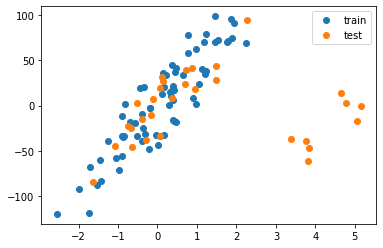

In [48]:
train_size = 70

plt.plot(X[:train_size], y[:train_size], 'o', label='train')
plt.plot(X[train_size:], y[train_size:], 'o', label='test')
plt.legend()
plt.show()

### Training

In [49]:
# X = add_axis_for_bias(X)

IndexError: index 1 is out of bounds for axis 1 with size 1

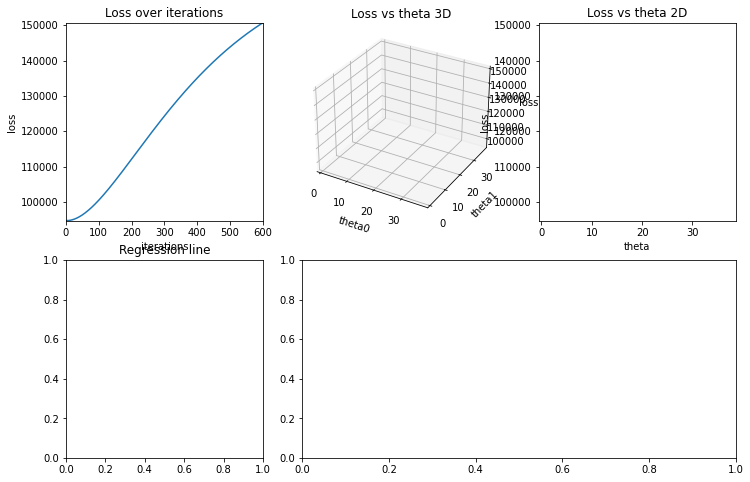

In [50]:
iterations = 600
learning_rate = 0.003
penalty = 0.0
train_size = 70

theta, theta_history, cost_history = ridge_regression_bgd(
    X[:train_size], y[:train_size], verbose=True, theta_precision = 0.001, 
    alpha = learning_rate ,iterations = iterations, 
    penalty = penalty
)


# anim = regression_animation(X[train_size:], y[train_size:], cost_history, 
#                             theta_history, iterations, interval=10)
# display.HTML(anim.to_html5_video())

regression_plot(X, y, cost_history, theta_history, iterations);

## Ridge with SGD

In [14]:
def ridge_regression_sgd(X, y, verbose=True, theta_precision = 0.001, batch_size=30, 
                         alpha = 0.01, iterations = 10000, penalty=1.0):
    X = add_axis_for_bias(X)
    
    # number of features+1 because of theta_0
    n = X.shape[1]
    m = y.shape[0]

    theta_history = []
    cost_history = []

    theta = np.random.rand(1,n) * theta_precision
#     if verbose: print("random initial θ value :",theta)
    
    for iteration in range(iterations):

        # creating indices for batches
        indices = np.random.randint(0, m, size=batch_size)

        # creating batch for this iteration
        X_batch = X[indices,:]
        y_batch = y[indices,:]

        # calculate y_pred 
        y_pred = predict(theta,X_batch)
        # new θ to replace old θ
        new_theta = None

        # simultaneous operation 
        gradient = derivative(X_batch,y_batch,y_pred)
        new_theta_0 = theta[:,[0]] - (alpha * gradient[0])
        new_theta_rest = (theta[:,range(1,n)] * (1 - ((penalty * alpha)/m)) ) - (alpha * gradient[1:])

        new_theta = np.hstack((new_theta_0,new_theta_rest)) 
        if np.isnan(np.sum(new_theta)) or np.isinf(np.sum(new_theta)):
            print("breaking. found inf or nan.")
            break
        # override with new θ 
        theta = new_theta

        # calculate cost to put in history
        cost = calculate_cost(y_pred = predict(theta,X_batch), y = y_batch)
        cost_history.append(cost)

        # calcualted theta in history
        theta_history.append(theta[0])
    return theta, np.array(theta_history), np.array(cost_history)

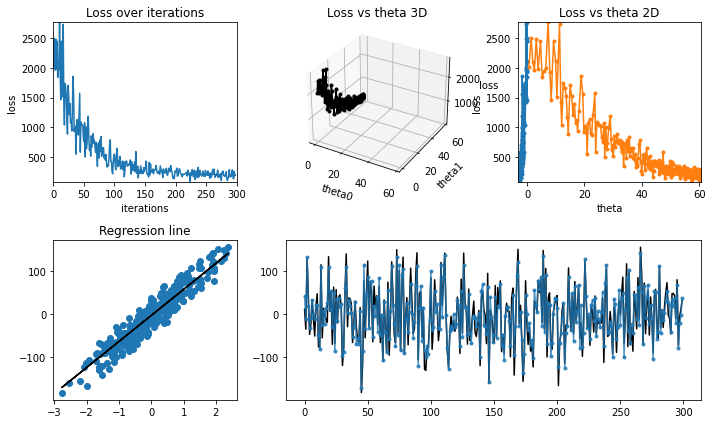

In [15]:
X = X1
y = y1.reshape(-1,1)
iterations = 300
learning_rate = 0.01
penalty = 1.0
theta1, theta_history, cost_history = ridge_regression_sgd(X, y, verbose=True, theta_precision = 0.001, 
                                                           alpha = learning_rate,iterations = iterations, 
                                                           penalty=penalty)

y_pred4 = predict(theta1,X)
anim = regression_animation(X, y, cost_history,theta_history, iterations, interval=30)
display.HTML(anim.to_html5_video())